<a href="https://colab.research.google.com/github/Zaza2800/PreDoc/blob/main/Personal%20Project/Ewen_ART_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.metrics import confusion_matrix


# Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
#Import dataset
import pathlib
import os
import zipfile

# Spécifier le chemin du fichier zip à dézipper
fichier_zip = '/content/wetransfer_art_2023-11-19_2132.zip'

# Spécifier le répertoire de destination pour extraire les fichiers
destination = '/content/image'

# Ouvrir le fichier zip
with zipfile.ZipFile(fichier_zip, 'r') as zip_ref:
    # Extraire tous les fichiers vers le répertoire de destination
    zip_ref.extractall(destination)

print("Le dossier a été dézippé avec succès.")

Le dossier a été dézippé avec succès.


In [ ]:
pictures = []
labels   = []

for dossier in ["prouvé", "random"]:
    dossier_complet = os.path.join('/content/image/ART', dossier)
    label = 1 if dossier == "prouvé" else 0

    for fichier in os.listdir(dossier_complet):
        chemin_image = os.path.join(dossier_complet, fichier)
        image = cv2.imread(chemin_image)

        if image is not None:
            # Redimensionnez l'image si nécessaire
            image = cv2.resize(image, (10, 10))
            image = image/255.0
            # Ajouter l'image et le label aux listes
            pictures.append(image)
            labels.append(label)

pictures = np.stack(pictures, axis=0)
#J'utilise pytorch -> tensor
pictures = torch.tensor(pictures)
print('picture shape :',pictures.shape)
labels = np.array(labels)
labels = torch.tensor(labels)
print('labels shape :',labels.shape)

picture shape : torch.Size([1917, 10, 10, 3])
labels shape : torch.Size([1917])


In [ ]:
pictures_train, pictures_test, labels_train, labels_test = train_test_split(pictures, labels, test_size=0.2, random_state=42)

In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self, in_dim):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.in_dim = in_dim
        self.features = nn.Sequential(
            nn.Conv2d(self.in_dim, out_channels = 32, kernel_size = 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2, padding =0),
            nn.Dropout(p=0.5),
            nn.Conv2d(in_channels=32, out_channels = 64, kernel_size = 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2, padding=0),
            nn.Dropout(p=0.5),
            nn.Conv2d(in_channels=64, out_channels = 64, kernel_size = 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2, padding=0)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(64, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 2),
            nn.Softmax(dim=1)
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.reshape(bsize, -1)
        #print(output.shape)
        output = self.classifier(output) # we compute the output of the fc layers
        return output



In [ ]:
from torch.utils.data import DataLoader, Dataset
class MyDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return {'image': image, 'label': label}



In [ ]:
import torch.nn.functional as F

model = ConvNet(3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
batch_size = 10

In [ ]:
#pictures_train, pictures_test, labels_train, labels_test
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(pictures_train, labels_train)
train_dl = torch.utils.data.DataLoader(train_dataset,
                        batch_size, shuffle=True)

val_dataset = TensorDataset(pictures_test, labels_test)
val_dl = torch.utils.data.DataLoader(val_dataset,
                        batch_size, shuffle=True)

In [ ]:
def training_dl(nb_epoch, model_dl, dataloader, optimizer, criterion):
  LOSS = []
  ACCURACY = []
  Y_esti_list = []


  for epoch in range(nb_epoch):
      total_loss = 0
      correct_predictions = 0
      total_samples = 0
      for X_batch, Y_batch in dataloader:
          optimizer.zero_grad()
          X_batch = X_batch.float()
          X_batch = X_batch.permute(0, 3, 1, 2)
          prediction = model_dl(X_batch)

          # Calcul de la perte
          loss = criterion(prediction, Y_batch)
          loss.backward()
          total_loss += loss.item()
          optimizer.step()

          # Calcul de l'exactitude
          _, Y_esti = torch.max(prediction, 1)
          correct_predictions += torch.sum(torch.eq(Y_esti, (Y_batch))).item()
          total_samples += len(Y_batch)

      # Calcul de la perte moyenne et de l'exactitude moyenne pour l'époque
      average_loss = total_loss / len(dataloader)
      accuracy = correct_predictions / total_samples

      # Enregistrement des valeurs
      LOSS.append(average_loss)
      ACCURACY.append(accuracy)

      print(f'Epoch [{epoch + 1}/{nb_epoch}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')


  return LOSS, ACCURACY, model_dl

In [ ]:
def test_dl(nb_epoch, model_dl, dataloader, optimizer, criterion):
  LOSS = []
  ACCURACY = []
  Y_esti_list = []

  model_dl.eval()
  for epoch in range(1):
      total_loss = 0
      correct_predictions = 0
      total_samples = 0
      with torch.no_grad():
        for X_batch, Y_batch in dataloader:
            X_batch = X_batch.float()
            X_batch = X_batch.permute(0, 3, 1, 2)
            prediction = model_dl(X_batch)

            # Calcul de la perte
            loss = criterion(prediction, Y_batch)

            total_loss += loss.item()

            # Calcul de l'exactitude
            _, Y_esti = torch.max(prediction, 1)
            for i in range(len(Y_batch)):
              print('catégorie : ',Y_batch[i].item(),'classé :',Y_esti[i].item())
            correct_predictions += torch.sum(torch.eq(Y_esti, (Y_batch))).item()
            total_samples += len(Y_batch)

        # Calcul de la perte moyenne et de l'exactitude moyenne pour l'époque
        average_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / total_samples

        # Enregistrement des valeurs
        LOSS.append(average_loss)
        ACCURACY.append(accuracy)

      print(f'Résultat de l evaluation, Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

  return LOSS, ACCURACY

In [ ]:
def training_test_dl(nb_epoch, model_dl, dataloader_train, dataloader_test, optimizer, criterion):
  LOSS_train = []
  LOSS_test  = []
  ACCURACY_train = []
  ACCURACY_test = []
  Y_esti_list_train = []
  Y_esti_list_test  = []


  for epoch in range(nb_epoch):
    ###### Train ######

      total_loss = 0
      correct_predictions = 0
      total_samples = 0
      for X_batch, Y_batch in dataloader_train :
          optimizer.zero_grad()
          X_batch = X_batch.float()
          X_batch = X_batch.permute(0, 3, 1, 2)
          prediction = model_dl(X_batch)

          # Calcul de la perte
          loss = criterion(prediction, Y_batch)
          loss.backward()
          total_loss += loss.item()
          optimizer.step()

          # Calcul de l'exactitude
          _, Y_esti = torch.max(prediction, 1)
          correct_predictions += torch.sum(torch.eq(Y_esti, (Y_batch))).item()
          total_samples += len(Y_batch)

      # Calcul de la perte moyenne et de l'exactitude moyenne pour l'époque
      average_loss = total_loss / len(dataloader_train)
      accuracy = correct_predictions / total_samples

      # Enregistrement des valeurs
      LOSS_train.append(average_loss)
      ACCURACY_train.append(accuracy)

      print(f'Epoch [{epoch + 1}/{nb_epoch}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

      ###### Test #####

      total_loss = 0
      correct_predictions = 0
      total_samples = 0
      with torch.no_grad():
        for X_batch, Y_batch in dataloader_test:
            X_batch = X_batch.float()
            X_batch = X_batch.permute(0, 3, 1, 2)
            prediction = model_dl(X_batch)

            # Calcul de la perte
            loss = criterion(prediction, Y_batch)

            total_loss += loss.item()

            # Calcul de l'exactitude
            _, Y_esti = torch.max(prediction, 1)
            correct_predictions += torch.sum(torch.eq(Y_esti, (Y_batch))).item()
            total_samples += len(Y_batch)

        # Calcul de la perte moyenne et de l'exactitude moyenne pour l'époque
        average_loss = total_loss / len(dataloader_test)
        accuracy = correct_predictions / total_samples

        # Enregistrement des valeurs
        LOSS_test.append(average_loss)
        ACCURACY_test.append(accuracy)

      print(f'Résultat de l evaluation, Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')



  return LOSS_train, ACCURACY_train, LOSS_test, ACCURACY_test, model_dl

In [ ]:
nb_epoch = 400
LOSS_train, ACCURACY_train, LOSS_test, ACCURACY_test, model = training_test_dl(nb_epoch, model, train_dl, val_dl, optimizer, criterion)

Epoch [1/400], Loss: 0.6720, Accuracy: 0.6354
Résultat de l evaluation, Loss: 0.6655, Accuracy: 0.6172
Epoch [2/400], Loss: 0.6595, Accuracy: 0.6360
Résultat de l evaluation, Loss: 0.6689, Accuracy: 0.6172
Epoch [3/400], Loss: 0.6615, Accuracy: 0.6360
Résultat de l evaluation, Loss: 0.6659, Accuracy: 0.6172
Epoch [4/400], Loss: 0.6596, Accuracy: 0.6360
Résultat de l evaluation, Loss: 0.6674, Accuracy: 0.6172
Epoch [5/400], Loss: 0.6580, Accuracy: 0.6360
Résultat de l evaluation, Loss: 0.6669, Accuracy: 0.6172
Epoch [6/400], Loss: 0.6565, Accuracy: 0.6360
Résultat de l evaluation, Loss: 0.6671, Accuracy: 0.6172
Epoch [7/400], Loss: 0.6532, Accuracy: 0.6360
Résultat de l evaluation, Loss: 0.6664, Accuracy: 0.6172
Epoch [8/400], Loss: 0.6506, Accuracy: 0.6360
Résultat de l evaluation, Loss: 0.6612, Accuracy: 0.6172
Epoch [9/400], Loss: 0.6430, Accuracy: 0.6360
Résultat de l evaluation, Loss: 0.6482, Accuracy: 0.6172
Epoch [10/400], Loss: 0.6328, Accuracy: 0.6360
Résultat de l evaluation, 

In [ ]:
#nb_epoch = 400
#LOSS_train, ACCURACY_train, model = training_dl(nb_epoch, model, train_dl, optimizer, criterion)


In [ ]:
model

ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=2, bias=True)
    (5): Softmax(dim=1)
  )
)

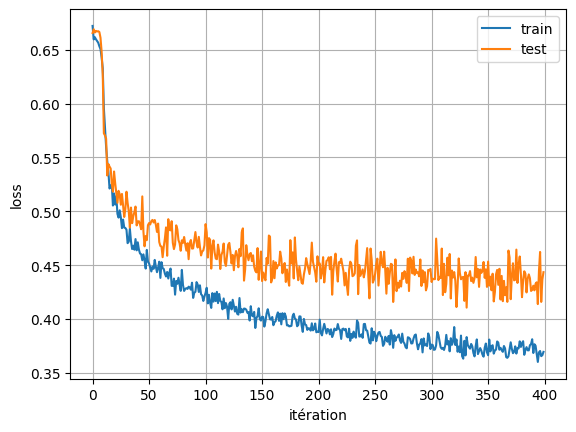

In [ ]:
plt.figure()
plt.plot(range(nb_epoch), LOSS_train, label = "train")
plt.plot(range(nb_epoch), LOSS_test , label = "test")
plt.xlabel("itération")
plt.ylabel("loss")
plt.legend()
plt.grid()

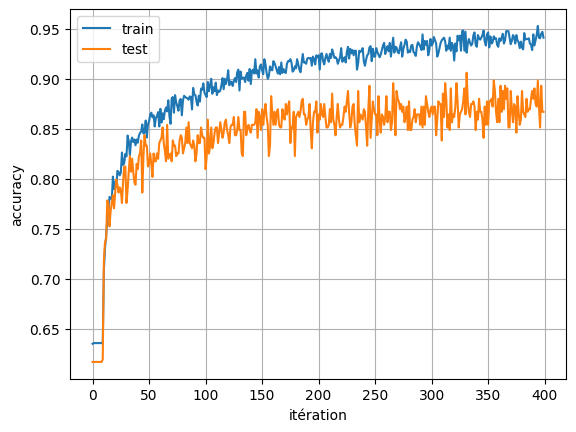

In [ ]:
plt.figure()
plt.plot(range(nb_epoch), ACCURACY_train, label = "train")
plt.plot(range(nb_epoch), ACCURACY_test , label = "test")
plt.xlabel("itération")
plt.ylabel("accuracy")
plt.legend()
plt.grid()

In [ ]:
LOSS_test, ACCURACY_test = test_dl(nb_epoch, model, val_dl, optimizer, criterion)

catégorie :  1 classé : 1
catégorie :  1 classé : 0
catégorie :  0 classé : 0
catégorie :  1 classé : 1
catégorie :  0 classé : 0
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  0 classé : 0
catégorie :  0 classé : 0
catégorie :  0 classé : 0
catégorie :  0 classé : 0
catégorie :  0 classé : 0
catégorie :  1 classé : 0
catégorie :  0 classé : 0
catégorie :  0 classé : 0
catégorie :  0 classé : 0
catégorie :  1 classé : 1
catégorie :  0 classé : 0
catégorie :  0 classé : 0
catégorie :  0 classé : 0
catégorie :  0 classé : 0
catégorie :  0 classé : 0
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  0 classé : 0
catégorie :  1 classé : 1
catégorie :  0 classé : 0
catégorie :  1 classé : 1
catégorie :  0 classé : 0
catégorie :  1 classé : 1
catégorie :  0 classé : 0
catégorie :  1 classé : 1
catégorie :  0 classé : 0
catégorie :  0 classé : 0
catégorie :  0 classé : 0
catégorie :  0 classé : 0
catégorie :  1 classé : 1
catégorie :  0 classé : 0
catégorie : 

## Test sur toutes les images prouvés

In [ ]:
pictures_p = []
labels_p   = []

for dossier in ["prouvé"]:
    dossier_complet = os.path.join('/content/image/ART', dossier)
    label = 1 if dossier == "prouvé" else 0

    for fichier in os.listdir(dossier_complet):
        chemin_image = os.path.join(dossier_complet, fichier)
        image_p = cv2.imread(chemin_image)

        if image_p is not None:
            # Redimensionnez l'image si nécessaire
            image_p = cv2.resize(image_p, (10, 10))
            image_p = image_p/255.0
            # Ajouter l'image et le label aux listes
            pictures_p.append(image_p)
            labels_p.append(label)

pictures_p = np.stack(pictures_p, axis=0)
#J'utilise pytorch -> tensor
pictures_p = torch.tensor(pictures_p)
print('picture shape :',pictures_p.shape)
labels_p = np.array(labels_p)
labels_p = torch.tensor(labels_p)
print('labels shape :',labels_p.shape)

picture shape : torch.Size([705, 10, 10, 3])
labels shape : torch.Size([705])


In [ ]:
# be sure only 1
labels_p.unique()

tensor([1])

In [ ]:
test_dataset = TensorDataset(pictures_p, labels_p)
test_dl1 = torch.utils.data.DataLoader(test_dataset,
                        batch_size, shuffle=True)

In [ ]:
LOSS_test, ACCURACY_test = test_dl(nb_epoch, model, test_dl1, optimizer, criterion)

catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 0
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie :  1 classé : 1
catégorie : 

In [ ]:
# Spécifiez le chemin où vous souhaitez sauvegarder le modèle
chemin_du_modele = '/content/model.pth'

# Sauvegardez le modèle
torch.save(model.state_dict(), chemin_du_modele)


In [ ]:
# Créez une instance du modèle
#modele_charge = ...

# Chargez les poids du modèle sauvegardé
#modele_charge.load_state_dict(torch.load(chemin_du_modele))

# Mettez le modèle en mode d'évaluation (si nécessaire)
#modele_charge.eval()